In [13]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

In [14]:
# Module


class CRFOCR(object):
    def __init__(self, img_width, img_height, _lambda ):
        self.img_width = img_width
        self.img_height = img_height
        self._lambda = _lambda

        # f_C the pobability for a character for a hidden state
        self.theta_C = np.zeros(26, dtype = np.float64)
        # f_I the probability for a pixel on a single state
        self.theta_I = np.zeros((2, 26, img_width*img_height), dtype = np.float64)
        # f_P the probability for adjacent pair operation
        self.theta_P = np.zeros((26,26), dtype = np.float64)

        print("init theta I as ", self.theta_I.shape)

    def calc_single_sum_theta_C(self, Y):

        return self.theta_C[Y]

    def calc_sum_theta_C(self, Y_arr):
        total_sum = 0
        for elem in Y_arr:
            total_sum += self.calc_single_sum_theta_C(elem)

        return total_sum

    def calc_single_sum_theta_I(self, x, Y):

        _sum = 0
        sub_x = self.theta_I[0,Y,:]
        # print(sub_x)
        mask = (x == 1)
        # print(mask)
        _sum += np.sum(sub_x[mask])

        # calculate those on 2 channel
        sub_x = self.theta_I[1,Y,:]
        mask = (x == 2)
        _sum += np.sum(sub_x[mask])
        return _sum
        

    def calc_sum_theta_I(self, X, Y_arr):
        total_sum = 0
        for i in range(X.shape[0]):
            elem_X = X[i,:]
            for elem_Y in Y_arr:
                total_sum += self.calc_single_sum_theta_I(elem_X, elem_Y)

        return total_sum 

    def calc_single_sum_theta_P(self, Y_pair):
        y1, y2 = Y_pair

        return self.theta_P[y1,y1]

    def calc_sum_theta_P(self, Y):
        num_y = Y.shape[0]
        if num_y<2:
            return 0

        total_sum = 0
        for i in range(num_y - 1):
            Y_pair = (Y[i], Y[i+ 1])
            total_sum += self.calc_single_sum_theta_P(Y_pair)
        return total_sum

    def calc_z(self, x):

        total_sum = 0
        for y1 in range(26):
            for y2 in range(26):
                for y3 in range(26):
                    y = np.array([y1, y2, y3])
                    total_sum += np.exp(self.calc_var_sum(x, y))
        return total_sum


    def calc_var_sum(self, x, y):
        total_sum = 0
        for i in range(y.shape[0]):
            y1 = y[i]
            x1 = x[i,:]
            total_sum += self.calc_single_sum_theta_I(x1,y1)
            total_sum += self.calc_single_sum_theta_C(y1)
            if i < y.shape[0] -1:
                y2 = y[i+1]
                total_sum += self.calc_single_sum_theta_P((y1,y2))
        return total_sum

    def calc_theta_e(self, x):
        """
         - x: 3 * 32
        """
        z = self.calc_z(x)
        delta_theta_C = np.zeros(26, dtype = np.float64)
        delta_theta_I = np.zeros((2, 26, self.img_height*self.img_width), dtype = np.float64)
        delta_theta_P = np.zeros((26, 26), dtype = np.float64)

        for y1 in range(26):
            for y2 in range(26):
                for y3 in range(26):
                    y = np.array([y1, y2, y3])
                    cond_prob = np.exp(self.calc_var_sum(x, y))/z
                    # print("Cnd Prob: ", cond_prob)
                    for i in range(y.shape[0]):

                        # theta_C
                        delta_theta_C[y[i]] += cond_prob

                        # theta_I layer 1
                        mask = x[i,:]
                        mask = (mask == 1) * cond_prob 
                        delta_theta_I[0,y[i],:] += mask

                        # theta_I layer 2
                        mask = x[i,:]
                        mask = (mask == 2) * cond_prob 
                        delta_theta_I[1,y[i],:] += mask

                        # theta_P
                        if i < (y.shape[0]-1):
                            delta_theta_P[y[i], y[i+1]] += cond_prob


        return delta_theta_C, delta_theta_I, delta_theta_P
    def calc_nll(self, x, y):

        """
        nll = log(Z) - sum( theta * sum(features) ) + lambda*0.5 * theta^2

         - x: 3*32 matrix
         - y: 1*3 array
        """
        nll = 0

        nll += np.log(self.calc_z(x))

        nll -= self.calc_var_sum(x,y)

        sum_weight = 0
        sum_weight += np.sum(np.square(self.theta_P))
        sum_weight += np.sum(np.square(self.theta_I))
        sum_weight += np.sum(np.square(self.theta_C))
        sum_weight *= (self._lambda*0.5)

        nll += sum_weight

        return nll


    def calc_nll_grad(self, x, y):
        # print("theta_C", self.theta_C.shape)
        # print("Theta_I", self.theta_I.shape)
        # print("Theta_P", self.theta_P.shape)
        delta_theta_C = np.zeros(26, dtype = np.float64)
        delta_theta_I = np.zeros((2, 26, self.img_height*self.img_width), dtype = np.float64)
        delta_theta_P = np.zeros((26, 26), dtype = np.float64)
        # E theta:
        d_c, d_i, d_p = self.calc_theta_e(x)
        # E D
        for i in range(y.shape[0]):
            # calc theta_c
            delta_theta_C[y[i]] -= 1
            # calc theta_I layer 1
            mask = x[i,:]
            mask = (mask == 1)
            delta_theta_I[0,y[i],:] -= mask

            # calc theta_I layer 2
            mask = x[i,:]
            mask = (mask == 2)
            delta_theta_I[1,y[i],:] -= mask

            # calc theta_P layer 3
            if i < (y.shape[0]-1):
                delta_theta_P[y[i], y[i+1]] -= 1

        # theta i:
        delta_theta_I += (self.theta_I * self._lambda + d_i)
        delta_theta_P += (self.theta_P * self._lambda + d_p)
        delta_theta_C += (self.theta_C * self._lambda + d_c)

        return delta_theta_C, delta_theta_I, delta_theta_P

    def eval_sum_loss(self, x_test, y_test):
        total_loss = 0
        for i in range(x_test.shape[0]):
            total_loss += self.calc_nll(x_test[i,:], y_test[i,:])

        return total_loss

    def SGD(self, x_batch, y_batch,x_test, y_test, _iter = 1, learning_rate = 0.003):
        steps = x_batch.shape[0]
        loss_list = []
        for i in range(_iter):
            for step in range(steps):
                learning_rate = 1/(1+0.05*step)
                delta_theta_C, delta_theta_I, delta_theta_P = self.calc_nll_grad(x_batch[step,:], y_batch[step,:])
                self.theta_C -= delta_theta_C * learning_rate
                self.theta_I -= delta_theta_I * learning_rate
                self.theta_P -= delta_theta_P * learning_rate
                nll = self.eval_sum_loss(x_test, y_test) / x_test.shape[0]
                loss_list.append(nll)

        return loss_list

### Setup Dataset: and module

In [15]:

DATASET_DIR = "q2dataset.mat"
INSTANCE_DIR = "q2instance.mat"


DATA_SET = sio.loadmat(DATASET_DIR)
def split_data(source):
    train_x = None
    train_y = None
    for i in range(source.shape[1]):
        raw = list(source[0,i])
        x,y = raw[0].reshape(1,3,32), raw[1]
        # print("x shape: ", x.shape)
        if train_x is None:
            train_x = x
            train_y = y
        else:
            train_x = np.vstack((train_x, x))
            train_y = np.vstack((train_y, y))
    print(train_x.shape)
    print(train_x[0,:])
    return train_x, train_y- 1

train_x, train_y = split_data(DATA_SET["trainData"])
test_x, test_y = split_data(DATA_SET["testData"])

INSTANCES = sio.loadmat(INSTANCE_DIR)

SAMPLE_PARAM = INSTANCES["sampleModelParams"]
SAMPLE_THETA = INSTANCES["sampleTheta"]
SAMPLE_X = INSTANCES["sampleX"]
SAMPLE_Y = INSTANCES["sampleY"]

# print("sample_X", SAMPLE_X.shape)
# print("sample y", SAMPLE_Y.shape)
crf = CRFOCR(8,4,0.003)





(220, 3, 32)
[[1 1 1 2 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 2 1 1 1 1 1 1 2 2 1 1 1]
 [1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 2 2 2 1 1 1 1 2 2 2 1 1 1]
 [1 1 1 2 2 1 1 1 1 2 2 2 2 2 1 1 1 2 1 1 2 2 2 1 1 2 1 1 2 1 1 1]]
(80, 3, 32)
[[2 2 2 2 2 2 2 2 2 1 1 1 2 1 1 2 2 1 1 1 2 1 1 2 2 1 1 1 1 1 2 2]
 [1 1 2 2 2 2 2 1 1 1 2 2 2 2 1 1 1 2 2 1 1 2 2 1 2 2 1 1 1 1 2 2]
 [2 2 2 1 1 1 1 1 2 1 2 2 2 2 2 2 2 1 1 2 1 1 1 1 2 2 2 2 1 1 1 1]]
init theta I as  (2, 26, 32)


### Answer to Instance NLL and Grad Norm:

In [16]:
print("Nll of the instance",crf.calc_nll(SAMPLE_X, SAMPLE_Y[0,:]))
grad_c, grad_i, grad_p = crf.calc_nll_grad(SAMPLE_X, SAMPLE_Y[0,:])

grad_c = grad_c.reshape(1, grad_c.shape[0])
grad_i = grad_i.reshape(1, 32*26*2)
grad_p = grad_p.reshape(1, 26*26)

grad = np.hstack((grad_c,grad_p, grad_i))
print("Gradient Norm: ", np.linalg.norm(grad))

Nll of the instance 9.77428961406
Gradient Norm:  9.62537942079


### Perform SGD and plot: 

In [17]:
a = crf.SGD(train_x, train_y,test_x[:10,:], test_y)
x = [i for i in range(len(a))]
plt.plot(x,a)
plt.show()

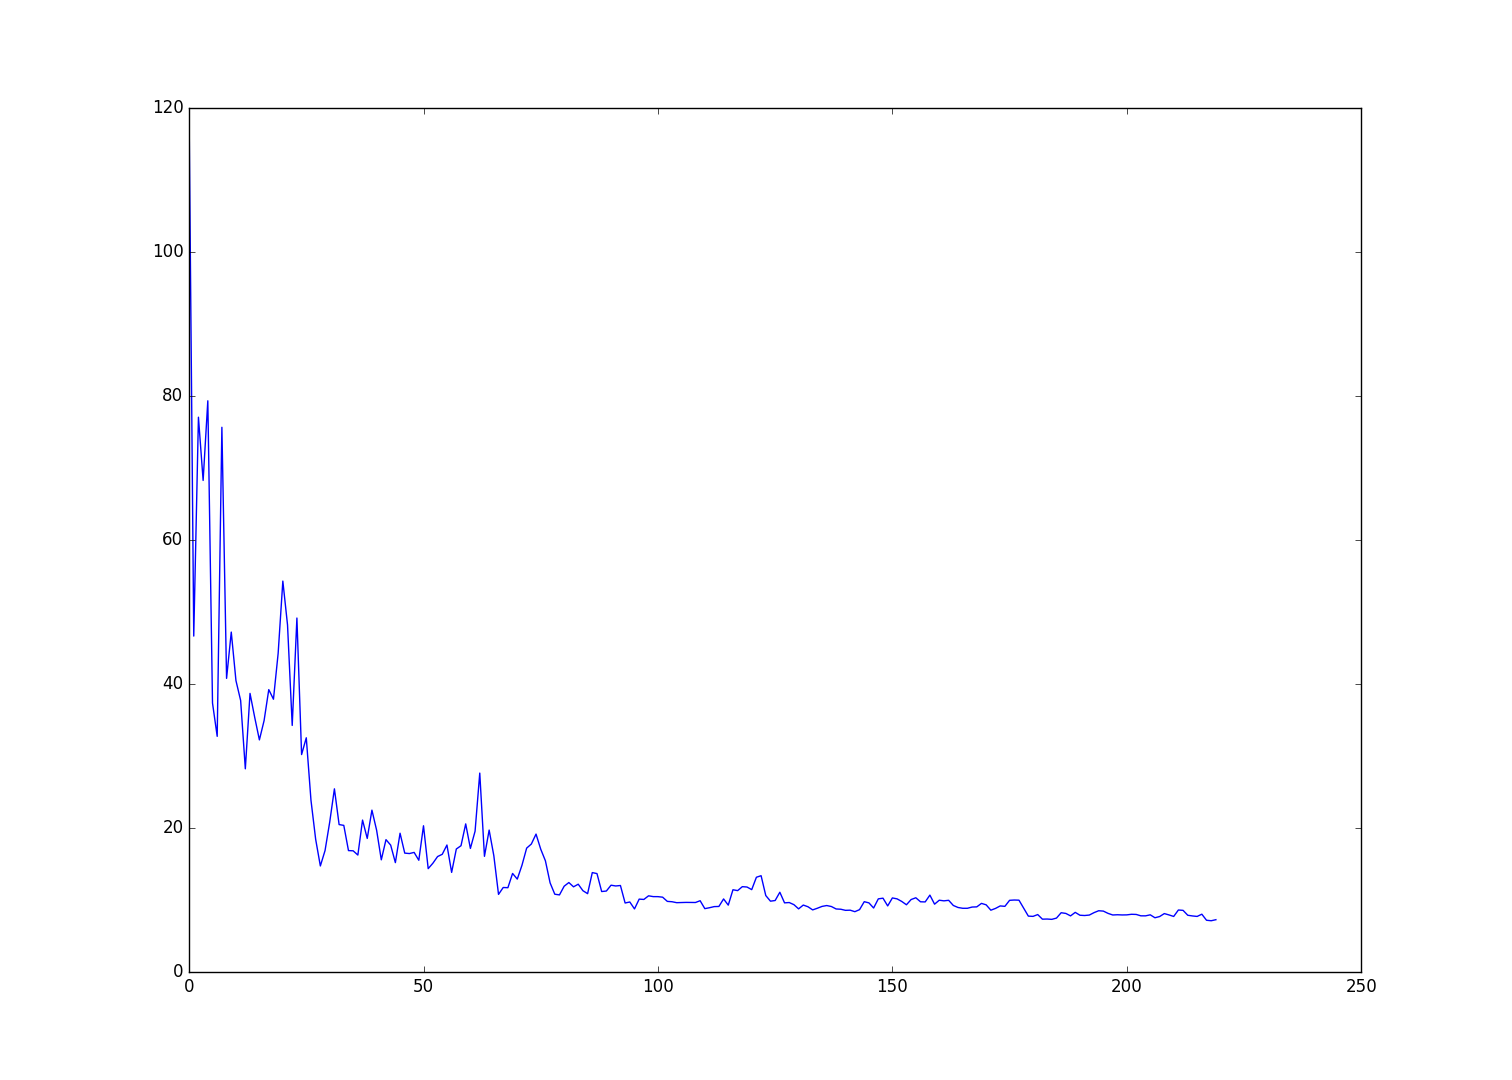

In [26]:
# for some unknown reason it shows on GUI rather than on notebook.
# if in doubt, feel free to just run the code
from IPython.display import Image, display
a = Image(filename = "figure1.png")
display(a)